## Vanishing Gradient Demo

This is a simple fully connected neural network to classify MNIST images. The gradients of the weights at each timestep are recorded and plotted to visualize how they change over time and how they compare to each other.  Try changing the number or size of layers to see how that affects the gradients.

In [68]:
# Import libraries and data
import tensorflow as tf
import numpy as np
from sklearn.cross_validation import StratifiedShuffleSplit
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# Read in the data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [11]:
# We'll train on a small subset of the training data of size 5000, but use this whole subset for training at each step.
# We do this to get a smoother graph of gradients.  SGD or mini-batch gradient descent is a lot noisier.
# Here, we get a stratified sample of the training set to make sure we have about equal number of each label in the 
# subset we'll be using.
label_numbers = [np.where(x==1)[0][0] for x in mnist.train.labels]
sss = StratifiedShuffleSplit(y=label_numbers, n_iter=1, test_size=5000, random_state=0)
   
for large_split_indices, small_split_indices in sss:
    small_split_data = mnist.train.images[small_split_indices]
    small_split_labels = mnist.train.labels[small_split_indices]

/Users/hsuresh/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [26]:
# Define our train, validation and testing sets
train_dataset = small_split_data
train_labels = small_split_labels
valid_dataset = mnist.validation.images
valid_labels = mnist.validation.labels
test_dataset = mnist.test.images
test_labels = mnist.test.labels

In [47]:
# We'll be using all of the small training subset at each step, to get smoother gradients.
train_subset = len(train_dataset)

# This is our lambda parameter for regularization.
y = .01

graph = tf.Graph()
with graph.as_default():

  # Load the training, validation and test data into constants that are
  # attached to the graph.
  tf_train_dataset = tf.constant(train_dataset)
  tf_train_labels = tf.cast(tf.constant(train_labels), tf.float32)
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Initialize the weights and biases, the parameters we'll be training.
  num_layers = 3
  weights_array = []
  biases_array = []
  layer_sizes = [image_size*image_size, 30, 30, num_labels]
  for i in range(num_layers):
    weights_array.append(tf.get_variable(('weight'+str(i)), shape=[layer_sizes[i], layer_sizes[i+1]],
           initializer=tf.contrib.layers.xavier_initializer()))
    biases_array.append(tf.Variable(tf.zeros([layer_sizes[i+1]])))
  

  # Train the network by sequentially multiplying inputs to weight matrices, adding biases, and taking
  # the sigmoid of the output.  We compute the softmax probabilities out of the last layer, and use the 
  # average cross-entropy across all samples plus regularization as our loss.
  logits = tf.nn.sigmoid(tf.matmul(tf_train_dataset, weights_array[0]) + biases_array[0])
  for i in range(1,num_layers-1):
    logits = tf.nn.sigmoid(tf.matmul(logits, weights_array[i]) + biases_array[i])
  logits = tf.matmul(logits, weights_array[num_layers-1]) + biases_array[num_layers-1]

  l2 = 0  # regularization term
  for i in range(num_layers):
      l2 += tf.nn.l2_loss(weights_array[i]) 
    
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + y*l2
  
  # Use gradient descent to calculate the gradients with respect to our parameters.
  # This is how we'll minimize the loss.
  opt = tf.train.GradientDescentOptimizer(0.5)
  grads_and_vars = opt.compute_gradients(loss)
  apply_grads = opt.minimize(loss)
  
  # Predictions 
  
  # Train
  train_prediction = tf.nn.softmax(logits)
    
  # Validation 
  logits = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_array[0]) + biases_array[0])
  for i in range(1,num_layers-1):
    logits = tf.nn.relu(tf.matmul(logits, weights_array[i]) + biases_array[i])
  logits = tf.matmul(logits, weights_array[num_layers-1]) + biases_array[num_layers-1]

  valid_prediction = tf.nn.softmax(logits)

  # Test
  logits = tf.nn.relu(tf.matmul(tf_test_dataset, weights_array[0]) + biases_array[0])
  for i in range(1,num_layers-1):
    logits = tf.nn.relu(tf.matmul(logits, weights_array[i]) + biases_array[i])
  logits = tf.matmul(logits, weights_array[num_layers-1]) + biases_array[num_layers-1]

  test_prediction = tf.nn.softmax(logits)

In [49]:
num_steps = 801

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

with tf.Session(graph=graph) as session:
  # One time operation to initialize the graph
  tf.initialize_all_variables().run()
  print('Initialized')

  # Initialize the dictionary we'll use to store the gradients
  var_to_grad = {}

  for step in range(num_steps):

    grad_vals, _, l, predictions = session.run([[grad for grad,_ in grads_and_vars], apply_grads, loss, train_prediction])
    
    # Add the gradients from each step to our dictionary
    for grad_val, (_, var) in zip(grad_vals, grads_and_vars):
        if var.name in var_to_grad:
            var_to_grad[var.name].append(np.mean(np.abs(grad_val)))
        else: 
            var_to_grad[var.name] = [np.mean(np.abs(grad_val))]
            
    if (step % 100 == 0):  
      print('Loss at step %d: %f' % (step, l))
      print('Training accuracy: %.1f%%' % accuracy(
        predictions, train_labels[:train_subset, :]))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Loss at step 0: 3.065974
Training accuracy: 9.6%
Validation accuracy: 15.3%
Loss at step 100: 2.253252
Training accuracy: 42.1%
Validation accuracy: 38.2%
Loss at step 200: 1.862471
Training accuracy: 59.3%
Validation accuracy: 53.2%
Loss at step 300: 1.682039
Training accuracy: 69.9%
Validation accuracy: 59.4%
Loss at step 400: 1.627816
Training accuracy: 74.8%
Validation accuracy: 63.7%
Loss at step 500: 1.598836
Training accuracy: 78.2%
Validation accuracy: 68.2%
Loss at step 600: 1.579048
Training accuracy: 79.9%
Validation accuracy: 72.3%
Loss at step 700: 1.566448
Training accuracy: 81.2%
Validation accuracy: 74.9%
Loss at step 800: 1.558378
Training accuracy: 81.6%
Validation accuracy: 75.9%
Test accuracy: 75.9%


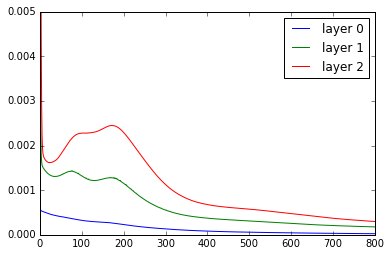

In [69]:
for l in range(num_layers):
    gradients = var_to_grad['weight'+str(l)+":0"]
    plt.plot(gradients, label="layer "+str(l))
ax = plt.axes() 
ax.set_ylim((0,.005))
plt.legend()